In [1]:
import psycopg2
import sys

import pandas as pd
import numpy as np
from matplotlib.pyplot import xticks
import matplotlib.pyplot as plt
plt.rc("font",size=14)
%matplotlib inline

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid",color_codes=True)


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

#from scipy.stats import chi2_contingency
#from scipy.stats import chi2
#import math

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
conn = psycopg2.connect(
                host="dwh-production.db.eigensonne.de",
                port="5432",
                database="eigensonne_dwh",
                user="amareid",
                password="ey4cMnS6Chni29G2H2iL",
                sslmode="require")


In [3]:
query = """select *
        from eigensonne_dwh.public.base3 """
cr = conn.cursor()
result = cr.execute(query)
cols = []

for col in cr.description:
    cols.append(col[0])
    
final_list=[]
for val in cr.fetchall():
    final_list.append(dict(zip(cols,val)))
    
cr.close()
base=pd.DataFrame(final_list)
base.head()


,id,lead_source,lead_medium,bundesland,radius_category,distance,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,75,57.0,Regular,0,0,0,21,0
1,00Q5J000003Zks7UAC,KP,affiliate,Hessen,75,40.0,Regular,0,0,0,0,0
2,00Q5J000003YCMeUAO,KP,affiliate,Berlin,35,5.0,Regular,1,0,0,12,0
3,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,35,7.0,Regular,1,0,0,11,0
4,00Q5J000003YpOpUAK,Wattfox,affiliate,Bayern,35,14.0,Regular,1,0,0,0,0


In [4]:
# DATA PREPARATION

#checking duplicates
sum(base.duplicated(subset = 'id')) == 0
# No duplicate values

True

In [5]:
print(base.shape)
base.dtypes

(16429, 12)


id                              object
lead_source                     object
lead_medium                     object
bundesland                      object
radius_category                 object
distance                       float64
record_type_name_c              object
has_opened                       int64
has_clicked_non_photo_url        int64
photo_upload                     int64
time_since_last_db_activity      int64
has_reached_wfp                  int64
dtype: object

In [6]:
#drop data closest team and radius category cause of duplocates
base=base.drop(['radius_category','distance'],1)

In [7]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16429 entries, 0 to 16428
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           16429 non-null  object
 1   lead_source                  16425 non-null  object
 2   lead_medium                  15575 non-null  object
 3   bundesland                   16350 non-null  object
 4   record_type_name_c           16429 non-null  object
 5   has_opened                   16429 non-null  int64 
 6   has_clicked_non_photo_url    16429 non-null  int64 
 7   photo_upload                 16429 non-null  int64 
 8   time_since_last_db_activity  16429 non-null  int64 
 9   has_reached_wfp              16429 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 1.3+ MB


In [8]:
base.describe()

,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
count,16429.000000,16429.000000,16429.000000,16429.000000,16429.000000
mean,0.710877,0.104328,0.188082,7.360643,0.347678
std,0.453369,0.305695,0.390790,9.700526,0.476248
min,0.000000,0.000000,0.000000,-1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,2.000000,0.000000
75%,1.000000,0.000000,0.000000,14.000000,1.000000
max,1.000000,1.000000,1.000000,103.000000,1.000000


In [9]:
base.isnull().sum()

id                               0
lead_source                      4
lead_medium                    854
bundesland                      79
record_type_name_c               0
has_opened                       0
has_clicked_non_photo_url        0
photo_upload                     0
time_since_last_db_activity      0
has_reached_wfp                  0
dtype: int64

In [10]:
#see percentage of null values to drop the once >= 70%

round(100*(base.isnull().sum()/len(base.index)), 2)

id                             0.00
lead_source                    0.02
lead_medium                    5.20
bundesland                     0.48
record_type_name_c             0.00
has_opened                     0.00
has_clicked_non_photo_url      0.00
photo_upload                   0.00
time_since_last_db_activity    0.00
has_reached_wfp                0.00
dtype: float64

In [11]:
# we will drop the columns having more than 70% NA values.
data = base.drop(base.loc[:,list(round(100*(base.isnull().sum()/len(base.index)), 2)>70)].columns, 1)

In [12]:
# Now we will take care of null values in each column one by one.
data['lead_source'].describe()

count       16425
unique         11
top       Wattfox
freq         5664
Name: lead_source, dtype: object

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 11 Text major ticklabel objects>)

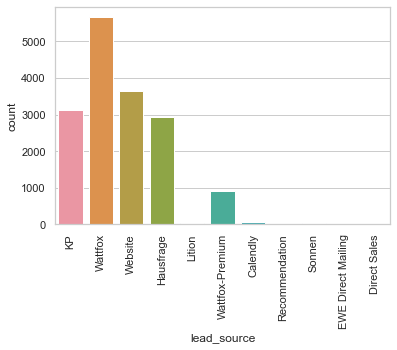

In [13]:
sns.countplot(data['lead_source'])
xticks(rotation = 90)

In [14]:
data.groupby(['lead_source'])['id'].count()

lead_source
Calendly                60
Direct Sales             3
EWE Direct Mailing       3
Hausfrage             2938
KP                    3119
Lition                  28
Recommendation          18
Sonnen                  22
Wattfox               5664
Wattfox-Premium        912
Website               3658
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

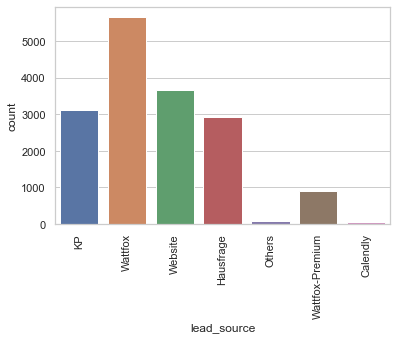

In [15]:
#taking into account that we always knows when leads come from affiliates, we will call the null values and 
#every lead comming from a source with a total of leads < 30 'Other'
data['lead_source'] = data['lead_source'].replace(np.nan, 'Others')
data['lead_source'] = data['lead_source'].replace(data.loc[data.groupby('lead_source').lead_source.transform('count').lt(30),
                               'lead_source'],'Others')

sns.countplot(data['lead_source'])
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

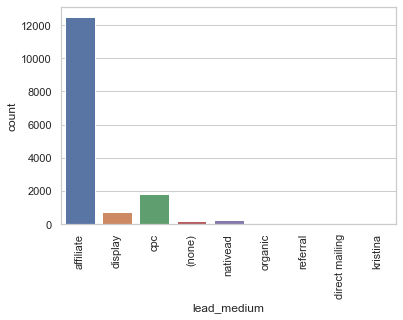

In [16]:
sns.countplot(data['lead_medium'])
xticks(rotation = 90)

In [17]:
data.groupby(['lead_medium'])['id'].count()

lead_medium
(none)              193
affiliate         12487
cpc                1791
direct mailing        3
display             753
kristina              1
nativead            243
organic              73
referral             31
Name: id, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

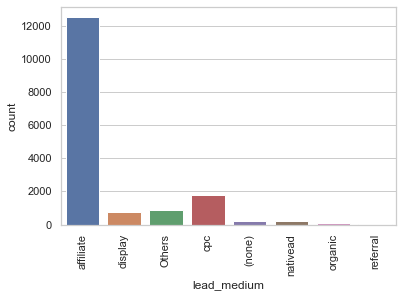

In [18]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a medium with a total of leads < 30 'Others'
data['lead_medium'] = data['lead_medium'].replace(np.nan, 'Others')
data['lead_medium'] = data['lead_medium'].replace(data.loc[data.groupby('lead_medium').lead_medium.transform('count').lt(30),
                               'lead_medium'],'Others')

sns.countplot(data['lead_medium'])
xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text major ticklabel objects>)

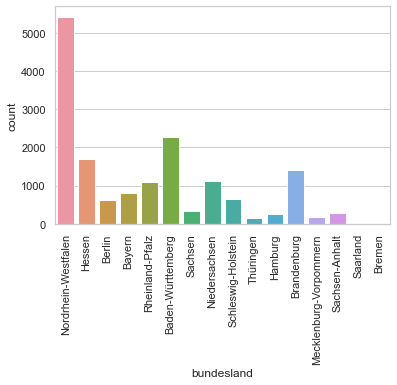

In [19]:
sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [20]:
data.groupby(['bundesland'])['id'].count()

bundesland
Baden-Württemberg         2285
Bayern                     794
Berlin                     629
Brandenburg               1406
Bremen                       6
Hamburg                    255
Hessen                    1695
Mecklenburg-Vorpommern     168
Niedersachsen             1130
Nordrhein-Westfalen       5426
Rheinland-Pfalz           1083
Saarland                    29
Sachsen                    345
Sachsen-Anhalt             289
Schleswig-Holstein         652
Thüringen                  158
Name: id, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

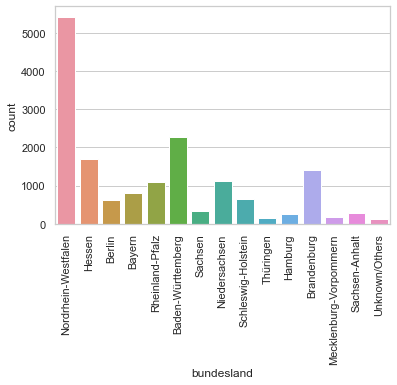

In [21]:
#taking into account that we always know when leads come from affiliates, we will call the null values and 
#every lead comming from a bundesland with a total of leads < 30 'Others'
data['bundesland'] = data['bundesland'].replace(np.nan, 'Unknown/Others')
data['bundesland'] = data['bundesland'].replace(data.loc[data.groupby('bundesland').lead_medium.transform('count').lt(30),
                               'bundesland'],'Unknown/Others')

sns.countplot(data['bundesland'])
xticks(rotation = 90)

In [22]:
#plt1 = sns.boxplot(data['distance'])
#xticks(rotation = 90)

In [23]:
# As we can see there are a number of outliers in the data.
# We will cap the outliers to 95% value for analysis.
#percentiles = data['distance'].quantile([0.00,0.95]).values
#data['distance'][data['distance'] <= percentiles[0]] = percentiles[0]
#data['distance'][data['distance'] >= percentiles[1]] = percentiles[1]
#sns.boxplot(data['distance'])

In [24]:
#data['distance'].median()

In [25]:
#sns.boxplot(y = 'distance', x = 'photo_upload', data = data)
#median for converted and non converted leads is the same

In [26]:
#we will substitute the missing data with the median 
#data['distance'] = data['distance'].replace(np.nan, data['distance'].median())


In [27]:
#sns.countplot(data['radius_category'])
#xticks(rotation = 90)

In [28]:
#data.groupby(['radius_category'])['id'].count()

In [29]:
#as we have substituted distance with the median (which is 37) we will substitude the category with 75
#data['radius_category'] = data['radius_category'].replace(np.nan, '75')


#sns.countplot(data['radius_category'])
#xticks(rotation = 90)

In [30]:
data['record_type_name_c'].describe()


count       16429
unique          2
top       Regular
freq        13109
Name: record_type_name_c, dtype: object

In [31]:
round(100*(data.isnull().sum()/len(data.index)), 2)

id                             0.0
lead_source                    0.0
lead_medium                    0.0
bundesland                     0.0
record_type_name_c             0.0
has_opened                     0.0
has_clicked_non_photo_url      0.0
photo_upload                   0.0
time_since_last_db_activity    0.0
has_reached_wfp                0.0
dtype: float64

In [32]:
#Exploratory Data Analytics
# Univariate Analysis 

In [33]:
Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

18.808205003347737

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

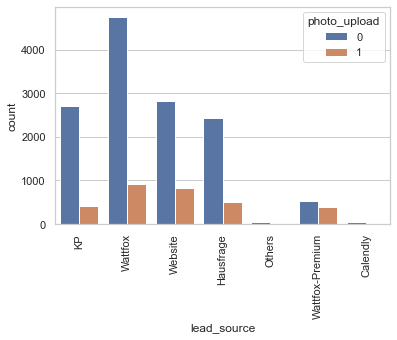

In [34]:
#lead_source 
sns.countplot(x = "lead_source", hue = "photo_upload", data = data)
xticks(rotation = 90)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

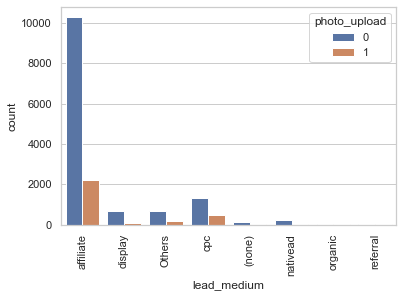

In [35]:
#lead_source 
sns.countplot(x = "lead_medium", hue = "photo_upload", data = data)
xticks(rotation = 90)

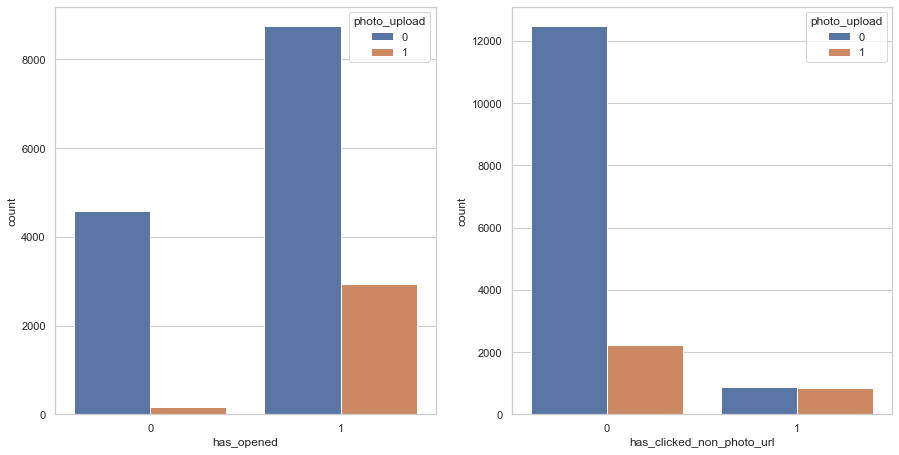

In [36]:
fig, axs = plt.subplots(1,2,figsize = (15,7.5))
sns.countplot(x = "has_opened", hue = "photo_upload", data = data, ax = axs[0])
sns.countplot(x = "has_clicked_non_photo_url", hue = "photo_upload", data = data, ax = axs[1])

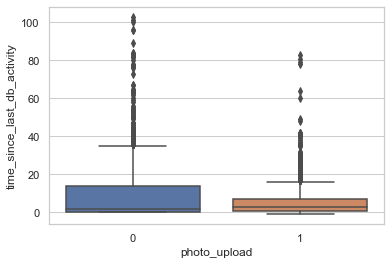

In [37]:
sns.boxplot(y = 'time_since_last_db_activity', x = 'photo_upload', data = data)

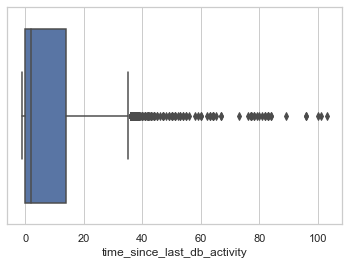

In [38]:
sns.boxplot(data['time_since_last_db_activity'])

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

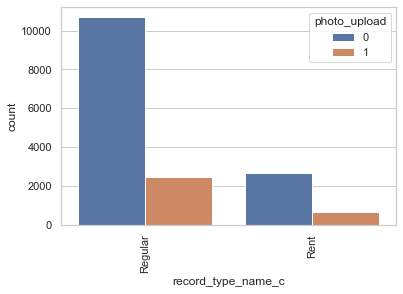

In [39]:
#record_type_name_c 
sns.countplot(x = "record_type_name_c", hue = "photo_upload", data = data)
xticks(rotation = 90)

In [40]:
data.head(10)

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,Regular,0,0,0,21,0
1,00Q5J000003Zks7UAC,KP,affiliate,Hessen,Regular,0,0,0,0,0
2,00Q5J000003YCMeUAO,KP,affiliate,Berlin,Regular,1,0,0,12,0
3,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,Regular,1,0,0,11,0
4,00Q5J000003YpOpUAK,Wattfox,affiliate,Bayern,Regular,1,0,0,0,0
5,00Q5J000003ZedkUAC,Wattfox,affiliate,Rheinland-Pfalz,Regular,1,0,0,15,1
6,00Q5J000003b0gTUAQ,Website,display,Baden-Württemberg,Rent,1,0,0,3,0
7,00Q5J000003YreOUAS,Website,display,Baden-Württemberg,Rent,0,0,0,3,0
8,00Q5J000003aaRvUAI,Hausfrage,affiliate,Rheinland-Pfalz,Rent,1,0,0,15,1
9,00Q5J000003azajUAA,Wattfox,affiliate,Sachsen,Rent,0,0,0,0,0


In [41]:
# Data Preparation



In [42]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source',# 'radius_category',
                           'lead_medium','bundesland']], drop_first=True)

# first value is dropped because the category variables enter the regression with the logic k-1. 
#For more information see:
#https://stats.stackexchange.com/questions/115049/why-do-we-need-to-dummy-code-categorical-variables


#dummy1 = pd.get_dummies(data[['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category']], 
#                        columns=['record_type_name_c','lead_source', 
#                           'lead_medium','bundesland', 'closest_team', 'radius_category'])

dummy1.head()

,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
# Adding the results to the master dataframe
data = pd.concat([data, dummy1], axis=1)
data.head()

,id,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003YQV8UAO,KP,affiliate,Nordrhein-Westfalen,Regular,0,0,0,21,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,00Q5J000003Zks7UAC,KP,affiliate,Hessen,Regular,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00Q5J000003YCMeUAO,KP,affiliate,Berlin,Regular,1,0,0,12,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003Z7SdUAK,Wattfox,affiliate,Nordrhein-Westfalen,Regular,1,0,0,11,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00Q5J000003YpOpUAK,Wattfox,affiliate,Bayern,Regular,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
data = data.drop(['lead_source', 'lead_medium',	'bundesland',#'radius_category',
                             'record_type_name_c'], axis = 1)


In [45]:
data.head(10)

,id,has_opened,has_clicked_non_photo_url,photo_upload,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,00Q5J000003YQV8UAO,0,0,0,21,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,00Q5J000003Zks7UAC,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00Q5J000003YCMeUAO,1,0,0,12,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00Q5J000003Z7SdUAK,1,0,0,11,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,00Q5J000003YpOpUAK,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,00Q5J000003ZedkUAC,1,0,0,15,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
6,00Q5J000003b0gTUAQ,1,0,0,3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,00Q5J000003YreOUAS,0,0,0,3,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,00Q5J000003aaRvUAI,1,0,0,15,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
9,00Q5J000003azajUAA,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [46]:
#train-test split 
# Putting feature variable to X
X = data.drop(['id','photo_upload'], axis=1)
X.head()

,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
0,0,0,21,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,12,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,11,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [47]:
y = data['photo_upload']

y.head()

0    0
1    0
2    0
3    0
4    0
Name: photo_upload, dtype: int64

In [48]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=None)

In [49]:
#feature scaling
scaler = StandardScaler()

X_train[['time_since_last_db_activity']] = scaler.fit_transform(
    X_train[['time_since_last_db_activity']])

X_train.head()

<ipython-input-49-84b74e90d621>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[['time_since_last_db_activity']] = scaler.fit_transform(
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
11762,1,0,-0.764741,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1214,1,1,1.303876,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
935,1,0,-0.557879,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3432,0,0,-0.661310,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13776,1,1,-0.454448,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
#How many conversions do we have 

Converted = (sum(data['photo_upload'])/len(data['photo_upload'].index))*100
Converted

18.808205003347737

In [51]:
#Model building 

In [52]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                11500
Model:                            GLM   Df Residuals:                    11467
Model Family:                Binomial   Df Model:                           32
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2307.7
Date:                Fri, 22 Jan 2021   Deviance:                       4615.4
Time:                        14:25:19   Pearson chi2:                 3.19e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -5.0195      0.763     -6.577      0.000      -6.515      -3.524
has_opened                            1.2828      0.128      9.992      0.000       1.031       1.534
has_clicked_non_photo_url             1.1824      0.106     11.112      0.000       0.974       1.391
time_since_last_db_activity          -2.1702      0.068    -31.816      0.000      -2.304      -2.036
has_reached_wfp                       5.6758      0.124     45.776      0.000       5.433       5.919
record_type_name_c_Rent              -0.3152      0.097     -3.233      0.001      -0.506      -0.124
lead_source_Hausfrage                -1.7058      0.828     -2.061      0.039      -3.328      -0.083
lead_source_KP                       -1.7825      0.830     -2.147      0.032      -3.410      -0.155
lead_source_Others                   -1.1357      0.939     -1.209      0.226      -2.976       0.705
lead_source_Wattfox                  -1.5166      0.825     -1.839      0.066      -3.133       0.100
lead_source_Wattfox-Premium          -2.0493      0.832     -2.464      0.014      -3.679      -0.420
lead_source_Website                  -0.2748      0.662     -0.415      0.678      -1.573       1.023
lead_medium_Others                   -0.1898      0.401     -0.473      0.636      -0.976       0.596
lead_medium_affiliate                 0.3223      0.650      0.496      0.620      -0.951       1.596
lead_medium_cpc                      -0.4737      0.369     -1.284      0.199      -1.197       0.249
lead_medium_display                  -0.9813      0.419     -2.342      0.019      -1.802      -0.160
lead_medium_nativead                 -0.8981      0.491     -1.830      0.067      -1.860       0.064
lead_medium_organic                  -0.7283      0.662     -1.101      0.271      -2.025       0.569
lead_medium_referral                 -0.0277      1.003     -0.028      0.978      -1.993       1.937
bundesland_Bayern                    -0.1841      0.210     -0.875      0.382      -0.597       0.228
bundesland_Berlin                     0.2897      0.211      1.371      0.170      -0.125       0.704
bundesland_Brandenburg               -0.1915      0.159     -1.202      0.229      -0.504       0.121
bundesland_Hamburg                    0.4794      0.353      1.356      0.175      -0.213       1.172
bundesland_Hessen                    -0.2781      0.157     -1.766      0.077      -0.587       0.030
bundesland_Mecklenburg-Vorpommern    -0.3657      0.450     -0.813      0.416      -1.247       0.515
bundesland_Niedersachsen              0.1504      0.182      0.826      0.409      -0.206       0.507
bundesland_Nordrhein-Westfalen       -0.1256      0.122     -1.031      0.303      -0.364       0.113
bundesland_Rheinland-Pf

In [53]:
# feature selection using RFE

logreg = LogisticRegression()

rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)
rfe.support_

/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([ True,  True,  True,  True,  True, False, False, False, False,
        True,  True, False, False,  True,  True,  True,  True, False,
       False,  True, False,  True, False,  True, False, False, False,
       False, False, False,  True, False])

In [54]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('has_opened', True, 1),
 ('has_clicked_non_photo_url', True, 1),
 ('time_since_last_db_activity', True, 1),
 ('has_reached_wfp', True, 1),
 ('record_type_name_c_Rent', True, 1),
 ('lead_source_Hausfrage', False, 3),
 ('lead_source_KP', False, 2),
 ('lead_source_Others', False, 11),
 ('lead_source_Wattfox', False, 4),
 ('lead_source_Wattfox-Premium', True, 1),
 ('lead_source_Website', True, 1),
 ('lead_medium_Others', False, 16),
 ('lead_medium_affiliate', False, 15),
 ('lead_medium_cpc', True, 1),
 ('lead_medium_display', True, 1),
 ('lead_medium_nativead', True, 1),
 ('lead_medium_organic', True, 1),
 ('lead_medium_referral', False, 17),
 ('bundesland_Bayern', False, 7),
 ('bundesland_Berlin', True, 1),
 ('bundesland_Brandenburg', False, 6),
 ('bundesland_Hamburg', True, 1),
 ('bundesland_Hessen', False, 5),
 ('bundesland_Mecklenburg-Vorpommern', True, 1),
 ('bundesland_Niedersachsen', False, 10),
 ('bundesland_Nordrhein-Westfalen', False, 8),
 ('bundesland_Rheinland-Pfalz', False, 

In [55]:
col = X_train.columns[rfe.support_]
col

Index(['has_opened', 'has_clicked_non_photo_url',
       'time_since_last_db_activity', 'has_reached_wfp',
       'record_type_name_c_Rent', 'lead_source_Wattfox-Premium',
       'lead_source_Website', 'lead_medium_cpc', 'lead_medium_display',
       'lead_medium_nativead', 'lead_medium_organic', 'bundesland_Berlin',
       'bundesland_Hamburg', 'bundesland_Mecklenburg-Vorpommern',
       'bundesland_Thüringen'],
      dtype='object')

In [56]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                11500
Model:                            GLM   Df Residuals:                    11484
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2317.0
Date:                Fri, 22 Jan 2021   Deviance:                       4634.0
Time:                        14:25:22   Pearson chi2:                 3.11e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                -6.3948      0.155    -41.284      0.000      -6.698      -6.091
has_opened                            1.2838      0.127     10.132      0.000       1.035       1.532
has_clicked_non_photo_url             1.1822      0.106     11.142      0.000       0.974       1.390
time_since_last_db_activity          -2.1635      0.068    -31.982      0.000      -2.296      -2.031
has_reached_wfp                       5.6467      0.122     46.107      0.000       5.407       5.887
record_type_name_c_Rent              -0.2798      0.096     -2.924      0.003      -0.467      -0.092
lead_source_Wattfox-Premium          -0.4275      0.114     -3.753      0.000      -0.651      -0.204
lead_source_Website                   0.8808      0.180      4.900      0.000       0.528       1.233
lead_medium_cpc                      -0.3003      0.205     -1.465      0.143      -0.702       0.101
lead_medium_display                  -0.8299      0.286     -2.905      0.004      -1.390      -0.270
lead_medium_nativead                 -0.7531      0.381     -1.975      0.048      -1.501      -0.006
lead_medium_organic                  -0.5401      0.590     -0.915      0.360      -1.697       0.617
bundesland_Berlin                     0.3636      0.189      1.925      0.054      -0.007       0.734
bundesland_Hamburg                    0.5349      0.340      1.571      0.116      -0.132       1.202
bundesland_Mecklenburg-Vorpommern    -0.2835      0.438     -0.647      0.518      -1.142       0.575
bundesland_Thüringen                 -0.6987      0.588     -1.188      0.235      -1.852       0.454
=====================================================================================================
"""

In [60]:
col2 = col.drop(['lead_medium_cpc',
                  'bundesland_Mecklenburg-Vorpommern','lead_medium_organic','bundesland_Thüringen'],1)
X_train_sm = sm.add_constant(X_train[col2])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           photo_upload   No. Observations:                11500
Model:                            GLM   Df Residuals:                    11488
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2319.2
Date:                Fri, 22 Jan 2021   Deviance:                       4638.4
Time:                        14:27:56   Pearson chi2:                 3.12e+07
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -6.3915      0.154    -41.370      0.000      -6.694      -6.089
has_opened                      1.2795      0.127     10.109      0.000       1.031       1.528
has_clicked_non_photo_url       1.1821      0.106     11.147      0.000       0.974       1.390
time_since_last_db_activity    -2.1630      0.068    -31.995      0.000      -2.295      -2.030
has_reached_wfp                 5.6412      0.122     46.183      0.000       5.402       5.881
record_type_name_c_Rent        -0.2836      0.096     -2.966      0.003      -0.471      -0.096
lead_source_Wattfox-Premium    -0.4235      0.114     -3.717      0.000      -0.647      -0.200
lead_source_Website             0.6580      0.107      6.161      0.000       0.449       0.867
lead_medium_display            -0.6260      0.245     -2.550      0.011      -1.107      -0.145
lead_medium_nativead           -0.5295      0.351     -1.507      0.132      -1.218       0.159
bundesland_Berlin               0.3756      0.189      1.989      0.047       0.005       0.746
bundesland_Hamburg              0.5520      0.340      1.625      0.104      -0.114       1.218
===============================================================================================
"""

In [61]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

11762    0.023903
1214     0.248065
935      0.019736
3432     0.006956
13776    0.955634
5268     0.106480
8474     0.000117
13607    0.030534
15078    0.041633
2315     0.019736
dtype: float64

In [62]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([2.39029027e-02, 2.48064507e-01, 1.97364261e-02, 6.95630707e-03,
       9.55633632e-01, 1.06479661e-01, 1.17270535e-04, 3.05336616e-02,
       4.16328706e-02, 1.97364261e-02])

In [63]:
#
y_train_pred_final = pd.DataFrame({'photo_upload':y_train.values, 'photo_upload_prob':y_train_pred})
y_train_pred_final['id'] = y_train.index
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id
0,0,0.023903,11762
1,1,0.248065,1214
2,0,0.019736,935
3,0,0.006956,3432
4,1,0.955634,13776


In [64]:
#Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0

y_train_pred_final['predicted'] = y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted
0,0,0.023903,11762,0
1,1,0.248065,1214,0
2,0,0.019736,935,0
3,0,0.006956,3432,0
4,1,0.955634,13776,1


In [65]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
print(confusion)


[[9051  295]
 [ 432 1722]]


In [66]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.predicted))

0.9367826086956522


In [67]:
# Check for the VIF values of the feature variables. 
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col2].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col2].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

# when VIF >5 then multicollinearity in our data is not severe enough to warrant corrective meassures
# to remove structural multicollinearity -> https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

,Features,VIF
6,lead_source_Website,4.69
7,lead_medium_display,3.12
8,lead_medium_nativead,2.03
3,has_reached_wfp,2.02
0,has_opened,1.93
9,bundesland_Berlin,1.36
4,record_type_name_c_Rent,1.34
1,has_clicked_non_photo_url,1.24
5,lead_source_Wattfox-Premium,1.21
2,time_since_last_db_activity,1.12


In [68]:
# metrics beyond simply accuracy
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [69]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7994428969359332

In [70]:
# Let us calculate specificity
TN / float(TN+FP)

0.9684356944147229

In [71]:
# positive predictive value 
print (TP / float(TP+FP))

0.8537431829449678


In [72]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9544447959506486


In [73]:
#An ROC curve demonstrates several things:

#It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be 
#accompanied by a decrease in specificity).
#The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

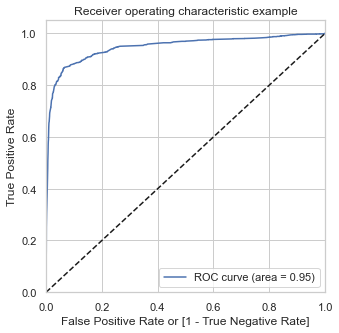

In [74]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.photo_upload, 
                                         y_train_pred_final.photo_upload_prob, drop_intermediate = False )
draw_roc(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

In [75]:
# Optimal cutoff probability is that prob where we get balanced sensitivity and specificity
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.photo_upload_prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.023903,11762,0,1,0,0,0,0,0,0,0,0,0
1,1,0.248065,1214,0,1,1,1,0,0,0,0,0,0,0
2,0,0.019736,935,0,1,0,0,0,0,0,0,0,0,0
3,0,0.006956,3432,0,1,0,0,0,0,0,0,0,0,0
4,1,0.955634,13776,1,1,1,1,1,1,1,1,1,1,1


In [76]:

# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.187304  1.000000  0.000000
0.1   0.1  0.858000  0.909471  0.846137
0.2   0.2  0.883391  0.887651  0.882410
0.3   0.3  0.923478  0.864903  0.936978
0.4   0.4  0.928696  0.833798  0.950567
0.5   0.5  0.936783  0.799443  0.968436
0.6   0.6  0.935391  0.738162  0.980847
0.7   0.7  0.927391  0.661096  0.988765
0.8   0.8  0.910087  0.551996  0.992617
0.9   0.9  0.858435  0.248839  0.998930


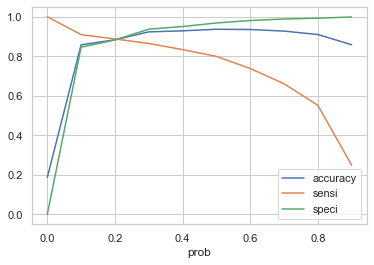

In [77]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [78]:
#### From the curve above, 0.1 is the optimum point to take it as a cutoff probability.

y_train_pred_final['final_predicted'] = y_train_pred_final.photo_upload_prob.map( lambda x: 1 if x > 0.2 else 0)

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.023903,11762,0,1,0,0,0,0,0,0,0,0,0,0
1,1,0.248065,1214,0,1,1,1,0,0,0,0,0,0,0,1
2,0,0.019736,935,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0.006956,3432,0,1,0,0,0,0,0,0,0,0,0,0
4,1,0.955634,13776,1,1,1,1,1,1,1,1,1,1,1,1


In [79]:
y_train_pred_final['Lead_Score'] = y_train_pred_final.photo_upload_prob.map( lambda x: round(x*100))

y_train_pred_final.head()

,photo_upload,photo_upload_prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,Lead_Score
0,0,0.023903,11762,0,1,0,0,0,0,0,0,0,0,0,0,2
1,1,0.248065,1214,0,1,1,1,0,0,0,0,0,0,0,1,25
2,0,0.019736,935,0,1,0,0,0,0,0,0,0,0,0,0,2
3,0,0.006956,3432,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0.955634,13776,1,1,1,1,1,1,1,1,1,1,1,1,96


In [80]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted)

confusion2 = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.final_predicted )
confusion2

TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8876508820798514

In [81]:
# Let us calculate specificity
TN / float(TN+FP)

0.8824095869890862

In [82]:
# Calculate false postive rate - predicting churn when customer does not have churned
print(FP/ float(TN+FP))

0.11759041301091376


In [83]:
# Positive predictive value 
print (TP / float(TP+FP))

0.6350049817336433


In [84]:
# Negative predictive value
print (TN / float(TN+ FN))

0.9714925197314171


In [85]:
# Precision and recall

#Looking at the confusion matrix again

confusion = metrics.confusion_matrix(y_train_pred_final.photo_upload, y_train_pred_final.predicted )
confusion

array([[9051,  295],
       [ 432, 1722]])

In [86]:
##### Precision
TP / TP + FP

confusion[1,1]/(confusion[0,1]+confusion[1,1])

0.8537431829449678

In [87]:
##### Recall
TP / TP + FN

confusion[1,1]/(confusion[1,0]+confusion[1,1])

0.7994428969359332

In [88]:
y_train_pred_final.photo_upload, y_train_pred_final.predicted

(0        0
 1        1
 2        0
 3        0
 4        1
         ..
 11495    1
 11496    0
 11497    0
 11498    0
 11499    0
 Name: photo_upload, Length: 11500, dtype: int64,
 0        0
 1        0
 2        0
 3        0
 4        1
         ..
 11495    1
 11496    0
 11497    0
 11498    1
 11499    0
 Name: predicted, Length: 11500, dtype: int64)

In [89]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.photo_upload, y_train_pred_final.photo_upload_prob)

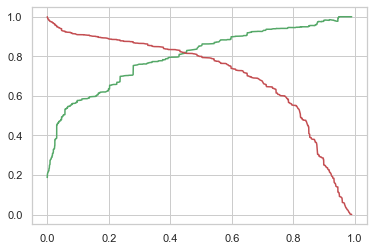

In [90]:
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [91]:
#Making predictions on the test set

X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])

X_train.head()

<ipython-input-91-c944f2535866>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[['time_since_last_db_activity']] = scaler.fit_transform(X_test[['time_since_last_db_activity']])
/Users/amareid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Hausfrage,lead_source_KP,lead_source_Others,lead_source_Wattfox,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_Others,lead_medium_affiliate,lead_medium_cpc,lead_medium_display,lead_medium_nativead,lead_medium_organic,lead_medium_referral,bundesland_Bayern,bundesland_Berlin,bundesland_Brandenburg,bundesland_Hamburg,bundesland_Hessen,bundesland_Mecklenburg-Vorpommern,bundesland_Niedersachsen,bundesland_Nordrhein-Westfalen,bundesland_Rheinland-Pfalz,bundesland_Sachsen,bundesland_Sachsen-Anhalt,bundesland_Schleswig-Holstein,bundesland_Thüringen,bundesland_Unknown/Others
11762,1,0,-0.764741,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1214,1,1,1.303876,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
935,1,0,-0.557879,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3432,0,0,-0.661310,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
13776,1,1,-0.454448,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
X_test = X_test[col2]
X_test.head()

,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp,record_type_name_c_Rent,lead_source_Wattfox-Premium,lead_source_Website,lead_medium_display,lead_medium_nativead,bundesland_Berlin,bundesland_Hamburg
5548,1,1,-0.131311,1,0,0,0,0,0,0,0
450,1,0,-0.642878,0,0,0,0,0,0,0,0
4405,1,0,0.687195,1,1,1,0,0,0,0,0
8778,1,0,-0.642878,1,1,0,0,0,0,0,0
6007,1,0,0.073315,0,0,0,0,0,0,0,0


In [93]:
X_test_sm = sm.add_constant(X_test)

In [94]:
#maiking predictions on the test set
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]


5548    0.880306
450     0.023626
4405    0.159187
8778    0.837011
6007    0.005114
4757    0.331045
420     0.946876
5601    0.021482
8303    0.235318
7055    0.235318
dtype: float64

In [95]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)
# Let's see the head
y_pred_1.head()

,0
5548,0.880306
450,0.023626
4405,0.159187
8778,0.837011
6007,0.005114


In [96]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)
# Putting CustID to index
y_test_df['id'] = y_test_df.index

# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

y_pred_final.head()

,photo_upload,id,0
0,1,5548,0.880306
1,0,450,0.023626
2,0,4405,0.159187
3,0,8778,0.837011
4,0,6007,0.005114


In [97]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'photo_upload_prob'})

# Rearranging the columns
#y_pred_final = y_pred_final.reindex_axis(['id','photo_upload','photo_upload_prob'], axis=1)

# Let's see the head of y_pred_final
y_pred_final.head()

,photo_upload,id,photo_upload_prob
0,1,5548,0.880306
1,0,450,0.023626
2,0,4405,0.159187
3,0,8778,0.837011
4,0,6007,0.005114


In [98]:
y_pred_final['final_predicted'] = y_pred_final.photo_upload_prob.map(lambda x: 1 if x > 0.2 else 0)
y_pred_final.head()

,photo_upload,id,photo_upload_prob,final_predicted
0,1,5548,0.880306,1
1,0,450,0.023626,0
2,0,4405,0.159187,0
3,0,8778,0.837011,1
4,0,6007,0.005114,0


In [99]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.photo_upload, y_pred_final.final_predicted)

0.8898356664637858

In [100]:
confusion2 = metrics.confusion_matrix(y_pred_final.photo_upload, y_pred_final.final_predicted )
confusion2

array([[3552,  441],
       [ 102,  834]])

In [101]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [102]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.8910256410256411

In [103]:
# Let us calculate specificity
TN / float(TN+FP)

0.8895567242674681

In [104]:
y_pred_final['Lead_Score'] = y_pred_final.photo_upload_prob.map( lambda x: round(x*100))

In [105]:
print(y_pred_final.shape)
y_pred_final.head()

(4929, 5)


,photo_upload,id,photo_upload_prob,final_predicted,Lead_Score
0,1,5548,0.880306,1,88
1,0,450,0.023626,0,2
2,0,4405,0.159187,0,16
3,0,8778,0.837011,1,84
4,0,6007,0.005114,0,1


In [106]:
y_train_pred_final=y_train_pred_final.drop(['predicted',0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],1)
print(y_train_pred_final.shape)
y_train_pred_final.head()

(11500, 5)


,photo_upload,photo_upload_prob,id,final_predicted,Lead_Score
0,0,0.023903,11762,0,2
1,1,0.248065,1214,1,25
2,0,0.019736,935,0,2
3,0,0.006956,3432,0,1
4,1,0.955634,13776,1,96


In [107]:
y_pred_final=y_pred_final[['id','photo_upload','photo_upload_prob','final_predicted','Lead_Score']]
y_train_pred_final=y_train_pred_final[['id','photo_upload','photo_upload_prob','final_predicted','Lead_Score']]

In [108]:
y_pred_final.head()

,id,photo_upload,photo_upload_prob,final_predicted,Lead_Score
0,5548,1,0.880306,1,88
1,450,0,0.023626,0,2
2,4405,0,0.159187,0,16
3,8778,0,0.837011,1,84
4,6007,0,0.005114,0,1


In [109]:
pred_values=pd.concat([y_train_pred_final,y_pred_final]).reset_index(drop=True)
pred_values.shape

(16429, 5)

In [110]:
pred_values.head()

,id,photo_upload,photo_upload_prob,final_predicted,Lead_Score
0,11762,0,0.023903,0,2
1,1214,1,0.248065,1,25
2,935,0,0.019736,0,2
3,3432,0,0.006956,0,1
4,13776,1,0.955634,1,96


In [111]:
Final= base.merge(pred_values, how='left',left_index=True,right_on='id', suffixes=('_left', '_right')).reset_index(drop=True)
Final.shape

(16429, 16)

In [112]:
Final.loc[Final.photo_upload_left != Final.photo_upload_right]

,id,id_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,photo_upload_left,time_since_last_db_activity,has_reached_wfp,id_right,photo_upload_right,photo_upload_prob,final_predicted,Lead_Score


In [114]:
Final=Final[['id_left','Lead_Score','photo_upload_left','lead_source','lead_medium','bundesland',#'radius_category','distance',
             'record_type_name_c','has_opened',	'has_clicked_non_photo_url',
             'time_since_last_db_activity',	'has_reached_wfp']]
Final.head(10)

,id_left,Lead_Score,photo_upload_left,lead_source,lead_medium,bundesland,record_type_name_c,has_opened,has_clicked_non_photo_url,time_since_last_db_activity,has_reached_wfp
0,00Q5J000003YQV8UAO,0,0,KP,affiliate,Nordrhein-Westfalen,Regular,0,0,21,0
1,00Q5J000003Zks7UAC,1,0,KP,affiliate,Hessen,Regular,0,0,0,0
2,00Q5J000003YCMeUAO,0,0,KP,affiliate,Berlin,Regular,1,0,12,0
3,00Q5J000003Z7SdUAK,0,0,Wattfox,affiliate,Nordrhein-Westfalen,Regular,1,0,11,0
4,00Q5J000003YpOpUAK,3,0,Wattfox,affiliate,Bayern,Regular,1,0,0,0
5,00Q5J000003ZedkUAC,24,0,Wattfox,affiliate,Rheinland-Pfalz,Regular,1,0,15,1
6,00Q5J000003b0gTUAQ,1,0,Website,display,Baden-Württemberg,Rent,1,0,3,0
7,00Q5J000003YreOUAS,0,0,Website,display,Baden-Württemberg,Rent,0,0,3,0
8,00Q5J000003aaRvUAI,19,0,Hausfrage,affiliate,Rheinland-Pfalz,Rent,1,0,15,1
9,00Q5J000003azajUAA,1,0,Wattfox,affiliate,Sachsen,Rent,0,0,0,0
